# Preliminary operations

We import the libraries and extract the zip file into the Colab environment.

In [ ]:
!pip install audiomentations

In [1]:
# Utility
from google.colab import drive
from shutil import copyfile, copy
import matplotlib.pyplot as plt
import IPython.display as ipd
import os
import pandas as pd
import numpy as np
import itertools

# Audio processing
import librosa
import librosa.display
import audiomentations

# Sklearn
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report, confusion_matrix, top_k_accuracy_score
from sklearn.preprocessing import StandardScaler, LabelEncoder

# Keras
import keras
from keras import regularizers
from keras.regularizers import l2
from keras.models import Sequential, Model
from keras.layers import Input, Dropout, Dense, Activation, LeakyReLU, Conv2D, MaxPooling2D, GlobalMaxPooling2D
from keras.optimizers import Adam
from keras.utils import np_utils, to_categorical
from keras.callbacks import EarlyStopping, ModelCheckpoint

In [3]:
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [4]:
!mkdir '/content/dataset'

In [5]:
copyfile('/content/gdrive/MyDrive/Digital Signal/Dataset/Audio_Speech_Actors_01-24.zip', 'speech.zip')

'speech.zip'

In [6]:
!unzip 'speech.zip' -d '/content/dataset'

Archive:  speech.zip
   creating: /content/dataset/Actor_01/
  inflating: /content/dataset/Actor_01/03-01-01-01-01-01-01.wav  
  inflating: /content/dataset/Actor_01/03-01-01-01-01-02-01.wav  
  inflating: /content/dataset/Actor_01/03-01-01-01-02-01-01.wav  
  inflating: /content/dataset/Actor_01/03-01-01-01-02-02-01.wav  
  inflating: /content/dataset/Actor_01/03-01-02-01-01-01-01.wav  
  inflating: /content/dataset/Actor_01/03-01-02-01-01-02-01.wav  
  inflating: /content/dataset/Actor_01/03-01-02-01-02-01-01.wav  
  inflating: /content/dataset/Actor_01/03-01-02-01-02-02-01.wav  
  inflating: /content/dataset/Actor_01/03-01-02-02-01-01-01.wav  
  inflating: /content/dataset/Actor_01/03-01-02-02-01-02-01.wav  
  inflating: /content/dataset/Actor_01/03-01-02-02-02-01-01.wav  
  inflating: /content/dataset/Actor_01/03-01-02-02-02-02-01.wav  
  inflating: /content/dataset/Actor_01/03-01-03-01-01-01-01.wav  
  inflating: /content/dataset/Actor_01/03-01-03-01-01-02-01.wav  
  inflating: /c

# Data exploration

Each filename consists of a 7-part numerical identifier (e.g., 03-01-06-01-02-01-12.wav). These identifiers represent:

*   Modality (01 = full-AV, 02 = video-only, 03 = audio-only).
*   Vocal channel (01 = speech, 02 = song).
*   Emotion (01 = neutral, 02 = calm, 03 = happy, 04 = sad, 05 = angry, 06 = fearful, 07 = disgust, 08 = surprised).
*   Emotional intensity (01 = normal, 02 = strong (not for neutral emotion)). 
*   Statement (01 = "Kids are talking by the door", 02 = "Dogs are sitting by the door").
*   Repetition (01 = 1st repetition, 02 = 2nd repetition).
*   Actor (01 to 24. Odd numbered actors are male, even numbered actors are female).

In [2]:
dir_list = os.listdir('/content/dataset/')
dir_list.sort()
dir_list

['Actor_01',
 'Actor_02',
 'Actor_03',
 'Actor_04',
 'Actor_05',
 'Actor_06',
 'Actor_07',
 'Actor_08',
 'Actor_09',
 'Actor_10',
 'Actor_11',
 'Actor_12',
 'Actor_13',
 'Actor_14',
 'Actor_15',
 'Actor_16',
 'Actor_17',
 'Actor_18',
 'Actor_19',
 'Actor_20',
 'Actor_21',
 'Actor_22',
 'Actor_23',
 'Actor_24']

In [3]:
count = [0] * 24
j = 0
for i in dir_list:
  filename = os.listdir('/content/dataset/' + i)
  for f in filename:
    if f.endswith('wav'): 
      count[j]+=1
  j+=1

In [4]:
count

[60,
 60,
 60,
 60,
 60,
 60,
 60,
 60,
 60,
 60,
 60,
 60,
 60,
 60,
 60,
 60,
 60,
 60,
 60,
 60,
 60,
 60,
 60,
 60]

24 subjects, each with 60 audio files.

Now let's divide the audio files according to their labels. We don't consider the neutral emotion because of two reasons: it has half the data then the other emotions and it's very similar to the calm emotion. We have found that the network cannot distinguish neutral class.

In [5]:
def switch(emotion):
  if emotion == 2:
    return 'calm'
  elif emotion == 3:
    return 'happy'
  elif emotion == 4:
    return 'sad'
  elif emotion == 5:
    return 'angry'
  elif emotion == 6:
    return 'fear'
  elif emotion == 7:
    return 'disgust'
  elif emotion == 8:
    return 'surprise'

In [6]:
emotion = []
path = []
for i in dir_list:
  filename = os.listdir('/content/dataset/' + i)
  for f in filename:
    # Remove wav extension
    id = f[:-4].split('-')
    if(id[2] != '01'):
      # Dividing according to emotions
      emotion.append(switch(int(id[2])))
      path.append('/content/dataset/' + i + '/' + f)

In [7]:
df = pd.concat([pd.DataFrame(emotion), pd.DataFrame(path)], axis = 1)
df.columns = ['emotion', 'path']
df['emotion'].value_counts()

surprise    192
happy       192
angry       192
fear        192
sad         192
calm        192
disgust     192
Name: emotion, dtype: int64

The dataset is perfectly balanced.

Let's pick some tracks.

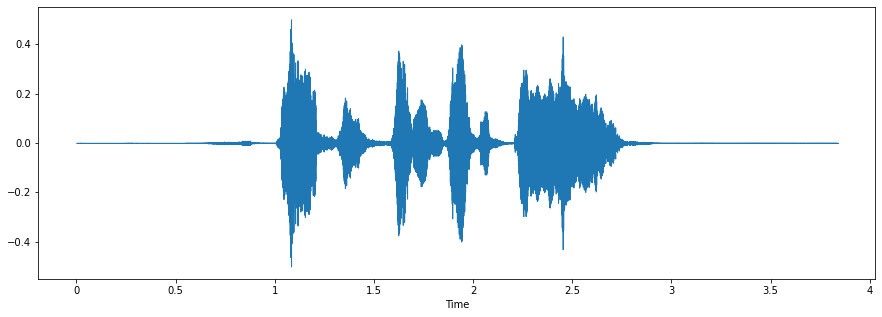

In [8]:
# Happy - Actor 14
filename = '/content/dataset/Actor_14/03-01-03-02-02-01-14.wav'  
data, sampling_rate = librosa.load(filename)

plt.figure(figsize = (15, 5))
librosa.display.waveshow(data, sr = sampling_rate)

ipd.Audio(filename)

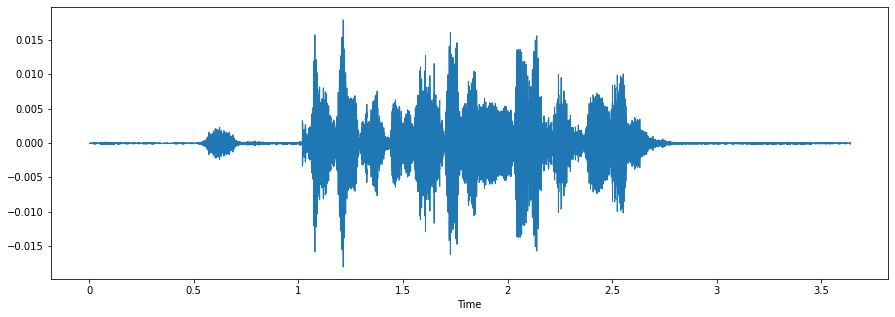

In [9]:
# Sad - Actor 9
filename = '/content/dataset/Actor_09/03-01-04-02-02-01-09.wav'  
data, sampling_rate = librosa.load(filename)

plt.figure(figsize = (15, 5))
librosa.display.waveshow(data, sr = sampling_rate)

ipd.Audio(filename)

We notice some initial noise due to the breath before speaking.

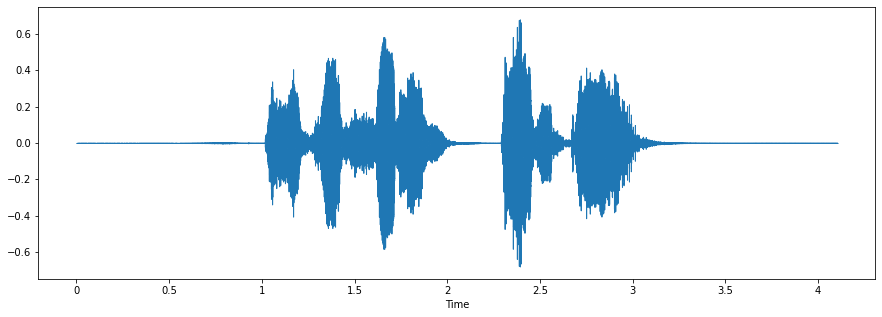

In [10]:
# Angry - Actor 21
filename = '/content/dataset/Actor_21/03-01-05-02-02-01-21.wav'  
data, sampling_rate = librosa.load(filename)

plt.figure(figsize = (15, 5))
librosa.display.waveshow(data, sr = sampling_rate)

ipd.Audio(filename)

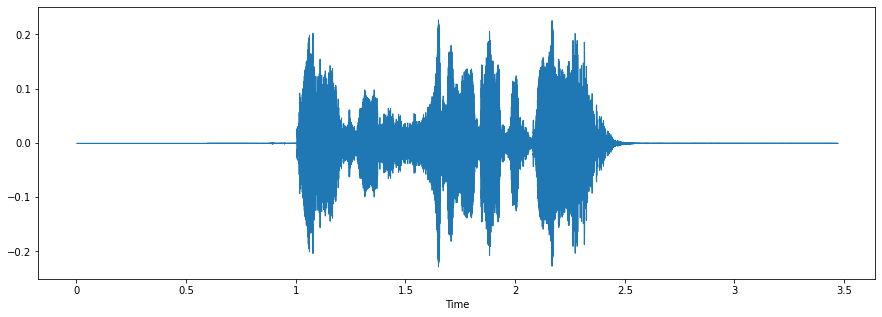

In [11]:
# Disgust - Actor 4
filename = '/content/dataset/Actor_04/03-01-08-02-02-01-04.wav'  
data, sampling_rate = librosa.load(filename)

plt.figure(figsize = (15, 5))
librosa.display.waveshow(data, sr = sampling_rate)

ipd.Audio(filename)

We can already notice a few things:
*   The duration is about 4 seconds.
*   There are some moments of silence at the beginning and at the end. We may remove them by picking just the central seconds.

Now, let's check the duration and the sampling rate for each statement.

In [12]:
duration = []
rate = []
for filename in df['path']:
  data, sampling_rate = librosa.load(filename, sr = 48000) # We want the native sr
  duration.append(data.shape[0])
  rate.append(sampling_rate)
print(np.unique(duration))
print(np.unique(rate))

[140941 142542 144144 145745 145746 147347 147348 148949 150550 150551
 152152 153753 153754 155355 155356 156956 156957 158558 158559 160160
 161761 161762 163363 163364 164964 164965 166566 166567 168168 169769
 169770 171371 171372 172972 172973 174574 174575 176176 177777 177778
 179379 179380 180980 180981 182582 182583 184184 185785 185786 187387
 187388 188988 188989 190590 190591 192192 193793 193794 195395 195396
 196996 196997 198598 198599 200200 201801 201802 203403 203404 205004
 205005 206606 206607 208208 209809 209810 211411 211412 213013 214614
 214615 216216 217817 217818 219419 219420 221020 221021 222622 222623
 224224 227427 229028 229029 230630 230631 232232 233834 235435 237037
 240240 245045 253053]
[48000]


The rate is the same for each sample. Let's have a better view of the durations.

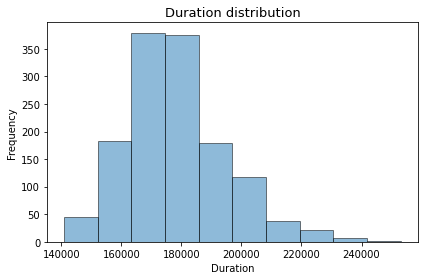

In [13]:
plt.title('Duration distribution', fontsize = 13)
plt.xlabel('Duration')
plt.ylabel('Frequency')
plt.hist(duration, alpha = 0.5, histtype = 'bar', ec = 'black')
plt.tight_layout()
plt.show() 

Duration in seconds = duration / 48000 (sample rate).

In [14]:
print(round(np.mean(duration), 2))
print(np.min(duration))
print(np.max(duration))

178309.1
140941
253053


Seems like we have a mean of ~180000 and a duration span of ~45000.

# Data processing

First of all, we cut the first and the last part of each sample in order to have a uniform duration of 3 seconds. 

In [15]:
audio = []
for filename in df['path']:
  data, sampling_rate = librosa.load(filename, sr = 48000, duration = 3, offset = 0.5) # We want the native sr
  audio.append(data)
df = pd.DataFrame(np.column_stack([df, audio]))
df.columns = ['emotion', 'path', 'data']

/usr/local/lib/python3.8/dist-packages/numpy/lib/shape_base.py:652: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  arr = asanyarray(v)


In [16]:
df.head()

,emotion,path,data
0,surprise,/content/dataset/Actor_01/03-01-08-01-01-02-01...,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
1,happy,/content/dataset/Actor_01/03-01-03-02-01-01-01...,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
2,angry,/content/dataset/Actor_01/03-01-05-01-02-01-01...,"[9.1552734e-05, 3.0517578e-05, 0.0, -3.0517578..."
3,happy,/content/dataset/Actor_01/03-01-03-01-01-02-01...,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
4,happy,/content/dataset/Actor_01/03-01-03-01-01-01-01...,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."


We pad with zeros the audio with length < 144000.

In [17]:
for i in range(len(df)):
  if(len(df['data'][i]) != 144000):
    start_pad = (144000 - len(df['data'][i]))//2
    end_pad = 144000 - len(df['data'][i]) - start_pad
    df['data'][i] = np.pad(df['data'][i], (start_pad, end_pad), mode = 'constant')

In [18]:
for i in range(len(df)):
  if(len(df['data'][i]) != 144000):
    print(len(df['data'][i]))

## Feature extraction

We extract the log Mel spectrogram.

Let's see an example.

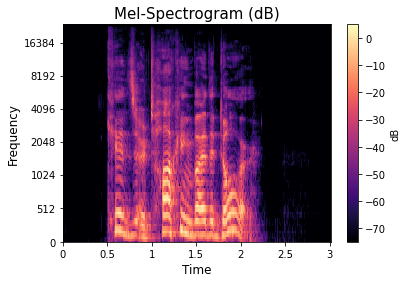

In [19]:
mel = librosa.power_to_db(librosa.feature.melspectrogram(df['data'][1]*1.0, sr = 48000, n_fft = 1024, n_mels = 128, fmin = 50, fmax = 24000)) 
plt.figure()
librosa.display.specshow(mel, sr = 48000, x_axis = 'time', y_axis = 'mel', cmap = 'magma')
plt.colorbar(label = 'dB')
plt.title('Mel-Spectrogram (dB)', fontdict = dict(size = 15))
plt.xlabel('Time', fontdict = dict(size = 12))
plt.ylabel('Frequency', fontdict = dict(size = 12))
plt.show()

In [20]:
def feature_extractor(input, feature, sr = 48000):
  # Mel Spectrogram
  if(feature == 'mel'):
    return librosa.power_to_db(librosa.feature.melspectrogram(input*1.0, sr = sr, n_fft = 1024, n_mels = 128, fmin = 50, fmax = 24000)) 

In [21]:
df['features'] = [0] * 1344
for i in range(len(df)):
  mel = feature_extractor(df['data'][i], 'mel')
  df['features'][i] = np.array(mel, dtype = object)

<ipython-input-21-d40640824df9>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['features'][i] = np.array(mel, dtype = object)
/usr/local/lib/python3.8/dist-packages/pandas/core/indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


We already split the dataset into training and test, in order to perform augmentation only on the training set. We use actors 21-24 for test.

In [22]:
X_test = df['features'][1120:1344].tolist()
y_test = df['emotion'][1120:1344].tolist()

In [23]:
X_train = df['features'][:1120].tolist()
y_train = df['emotion'][:1120].tolist()

## Data augmentation

This phase is performed in the following way;
1.   We add noise for all the signals.
2.   We pitch all the signals.
3.   We stretch all the signals.
4.   We shift all the signals.

In the end, we'll have the following data:
*   Original dataset.
*   Noise dataset.
*   Pitch dataset.
*   Stretch dataset.
*   Shift dataset.

### Noise

In [24]:
noise = audiomentations.Compose([
    audiomentations.AddGaussianNoise(p = 1)
])

In [25]:
for i in range(1120):
  augmented_samples = noise(df['data'][i], 48000)
  mel = feature_extractor(augmented_samples, 'mel')
  X_train.append(np.array(mel, dtype = object))
  y_train.append(df['emotion'][i])

### Pitch

In [26]:
pitchShift = audiomentations.Compose([
    audiomentations.PitchShift(p = 1)
])

In [27]:
for i in range(1120):
  augmented_samples = pitchShift(df['data'][i], 48000)
  mel = feature_extractor(augmented_samples, 'mel')
  X_train.append(np.array(mel, dtype = object))
  y_train.append(df['emotion'][i])

### Stretch

In [28]:
stretch = audiomentations.Compose([
    audiomentations.TimeStretch(p = 1)
])

In [29]:
for i in range(1120):
  augmented_samples = stretch(df['data'][i], 48000)
  mel = feature_extractor(augmented_samples, 'mel')
  X_train.append(np.array(mel, dtype = object))
  y_train.append(df['emotion'][i])

### Shift

In [30]:
shift = audiomentations.Compose([
    audiomentations.Shift(min_fraction = 0.25, max_fraction = 0.25, rollover = False, p = 1)
])

In [31]:
for i in range(1120):  
  augmented_samples = shift(df['data'][i], 48000)
  mel = feature_extractor(augmented_samples, 'mel')
  X_train.append(np.array(mel, dtype = object))
  y_train.append(df['emotion'][i])

In [32]:
print('We obtained ' + str(len(X_train)) + ' samples.')

We obtained 5600 samples.


## Split train-test

We load and normalize the data.

In [33]:
for i in range(len(X_train)):
  X_train[i] = X_train[i].astype(np.float64)
for i in range(len(X_test)):
  X_test[i] = X_test[i].astype(np.float64)

X_train = np.array(X_train)
y_train = np.array(y_train)
X_test = np.array(X_test)
y_test = np.array(y_test)

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train.reshape(-1, X_train.shape[-1])).reshape(X_train.shape)
X_test = scaler.transform(X_test.reshape(-1, X_test.shape[-1])).reshape(X_test.shape)

In [34]:
# One-hot encode the target 
lb = LabelEncoder()
y_train = np_utils.to_categorical(lb.fit_transform(y_train))
y_test = np_utils.to_categorical(lb.fit_transform(y_test))

In [35]:
# Making data compatible for the model
X_train = np.expand_dims(X_train, axis = 3)
X_test = np.expand_dims(X_test, axis = 3)
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((5600, 128, 282, 1), (5600, 7), (224, 128, 282, 1), (224, 7))

In [36]:
df = 0

# Model selection

We instanciate our first model with 3 Conv2D layers, 2 Dense layers, ReLU activations and MaxPooling2D. The output will be provided by the softmax function.

## Model 0: vanilla data

In this preliminary model we use the data "vanilla" (i.e. not augmented).

In [ ]:
X_train_vanilla = X_train[:896]
y_train_vanilla = y_train[:896]
X_val = X_train[896:1120]
y_val = y_train[896:1120]
X_train_vanilla.shape, y_train_vanilla.shape, X_val.shape, y_val.shape, X_test.shape, y_test.shape

((896, 128, 282, 1),
 (896, 7),
 (224, 128, 282, 1),
 (224, 7),
 (224, 128, 282, 1),
 (224, 7))

In [ ]:
num_classes = 7

model0 = Sequential()

model0.add(Conv2D(32, (3, 3), activation = 'relu', input_shape = (128, 282, 1)))
model0.add(MaxPooling2D((2, 2)))

model0.add(Conv2D(64, (3, 3), activation = 'relu'))
model0.add(MaxPooling2D((2, 2)))

model0.add(Conv2D(64, (3, 3), activation = 'relu'))
model0.add(GlobalMaxPooling2D())

model0.add(Dense(64, activation = 'relu'))

model0.add(Dense(num_classes, activation = 'softmax'))

model0.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 126, 280, 32)      320       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 63, 140, 32)      0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 61, 138, 64)       18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 30, 69, 64)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 28, 67, 64)        36928     
                                                                 
 global_max_pooling2d (Globa  (None, 64)               0

In [ ]:
stop_early = EarlyStopping(monitor = 'val_loss', patience = 10, restore_best_weights = True)

In [ ]:
model0.compile(loss = 'categorical_crossentropy', optimizer = Adam(learning_rate = 0.001), metrics = ['accuracy'])
history0 = model0.fit(X_train_vanilla, y_train_vanilla, batch_size = 32, epochs = 100, validation_data = (X_val, y_val), callbacks = [stop_early])

Epoch 1/100
28/28 [==============================] - 10s 45ms/step - loss: 1.9001 - accuracy: 0.2031 - val_loss: 1.8370 - val_accuracy: 0.2366
Epoch 2/100
28/28 [==============================] - 1s 38ms/step - loss: 1.7428 - accuracy: 0.2701 - val_loss: 1.7499 - val_accuracy: 0.2991
Epoch 3/100
28/28 [==============================] - 1s 38ms/step - loss: 1.6914 - accuracy: 0.3214 - val_loss: 1.7411 - val_accuracy: 0.2991
Epoch 4/100
28/28 [==============================] - 1s 36ms/step - loss: 1.6532 - accuracy: 0.3259 - val_loss: 1.7211 - val_accuracy: 0.2723
Epoch 5/100
28/28 [==============================] - 1s 39ms/step - loss: 1.6443 - accuracy: 0.3125 - val_loss: 1.8008 - val_accuracy: 0.2857
Epoch 6/100
28/28 [==============================] - 1s 39ms/step - loss: 1.6276 - accuracy: 0.3382 - val_loss: 1.7067 - val_accuracy: 0.3080
Epoch 7/100
28/28 [==============================] - 1s 40ms/step - loss: 1.6019 - accuracy: 0.3571 - val_loss: 1.6656 - val_accuracy: 0.3080
Epoch

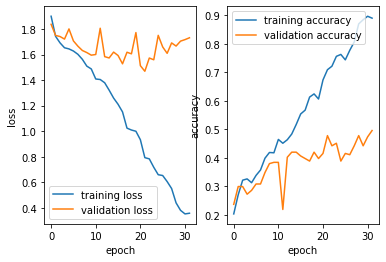

In [ ]:
plt.subplot(1,2,1)
plt.plot(history0.history['loss'])
plt.plot(history0.history['val_loss'])
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['training loss', 'validation loss'])

plt.subplot(1,2,2)
plt.plot(history0.history['accuracy'])
plt.plot(history0.history['val_accuracy'])
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.legend(['training accuracy', 'validation accuracy'])

In [ ]:
y_pred = model0.predict(X_val)
y_pred_ = np.argmax(y_pred, axis = 1)
y_val_ = np.argmax(y_val, axis = 1)
print(classification_report(y_val_, y_pred_))

7/7 [==============================] - 0s 15ms/step
              precision    recall  f1-score   support

           0       0.50      0.38      0.43        32
           1       0.64      0.72      0.68        32
           2       0.54      0.81      0.65        32
           3       0.36      0.38      0.37        32
           4       0.34      0.34      0.34        32
           5       0.09      0.03      0.05        32
           6       0.55      0.69      0.61        32

    accuracy                           0.48       224
   macro avg       0.43      0.48      0.45       224
weighted avg       0.43      0.48      0.45       224



Mapping:
0. Angry.
1. Calm.
2. Disgust.
3. Fear.
4. Happy.
5. Sad.
6. Surprise.

Text(0, 0.5, 'Prediction')

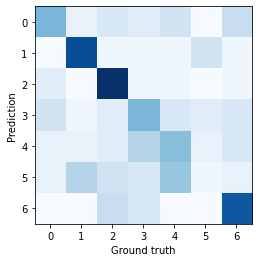

In [ ]:
cm = confusion_matrix(y_val_, y_pred_)
plt.imshow(cm, cmap = plt.cm.Blues)
plt.xlabel('Ground truth')
plt.ylabel('Prediction')

In [ ]:
print(top_k_accuracy_score(y_val_, y_pred, k = 2))
print(top_k_accuracy_score(y_val_, y_pred, k = 3))

0.6875
0.8169642857142857


## Grid search CV

Now we can perform a grid search on various hyperparameters. In particular, this search is performed on the basis of a 5-Folds Cross-Validation. For each fold, the validation set is composed by 4 different actors.

In [ ]:
alpha = [0.00, 0.01]
dropout = [0.2, 0.4]
k_reg = [0.01, 0.001]
b_reg = [0.01, 0.001]

params = [{'alpha': item[0],
           'dropout': item[1],
           'k_reg': item[2],
           'b_reg': item[3]
            } for item in
              list(itertools.product(*[alpha,
                                       dropout,
                                       k_reg,
                                       b_reg]))
          ]

In [ ]:
# Splitting dataset into 5 folds
X_train_CV = []
y_train_CV = []
X_val_CV= []
y_val_CV = []
X_train_ = np.concatenate((X_train_vanilla, X_val), axis = 0)
y_train_ = np.concatenate((y_train_vanilla, y_val), axis = 0)
for i in range(0, 5):
  start = i*4*56
  end = start + 224
  index =  list(range(start, end))
  X_val_CV.append(X_train_[start:end])
  y_val_CV.append(y_train_[start:end])
  X_train_CV.append(np.concatenate((X_train_[0:start], X_train_[end:1120]), axis = 0))
  y_train_CV.append(np.concatenate((y_train_[0:start], y_train_[end:1120]), axis = 0))

In [ ]:
for i in X_train_CV:
  print(i.shape)

(896, 128, 282, 1)
(896, 128, 282, 1)
(896, 128, 282, 1)
(896, 128, 282, 1)
(896, 128, 282, 1)


In [ ]:
results = []
stop_early = EarlyStopping(monitor = 'val_loss', patience = 10, restore_best_weights = True)
for param in params:
  score1 = []
  score2 = []
  score3 = []
  for i in range(5):
    num_classes = 7

    modelCV = Sequential()

    modelCV.add(Conv2D(32, (3, 3), input_shape = (128, 282, 1)))
    modelCV.add(LeakyReLU(param['alpha']))
    modelCV.add(MaxPooling2D((2, 2)))

    modelCV.add(Conv2D(64, (3, 3), kernel_regularizer = l2(param['k_reg']), bias_regularizer = l2(param['b_reg'])))
    modelCV.add(LeakyReLU(param['alpha']))
    modelCV.add(MaxPooling2D((2, 2)))
    modelCV.add(Dropout(param['dropout']))

    modelCV.add(Conv2D(64, (3, 3), kernel_regularizer = l2(param['k_reg']), bias_regularizer = l2(param['b_reg'])))
    modelCV.add(LeakyReLU(param['alpha']))
    modelCV.add(GlobalMaxPooling2D())
    modelCV.add(Dropout(param['dropout']))

    modelCV.add(Dense(64, kernel_regularizer = l2(param['k_reg']), bias_regularizer = l2(param['b_reg'])))
    modelCV.add(LeakyReLU(param['alpha']))
    modelCV.add(Dropout(param['dropout']))

    modelCV.add(Dense(num_classes, activation = 'softmax'))

    modelCV.compile(loss = 'categorical_crossentropy', optimizer = Adam(learning_rate = 0.001), metrics = ['accuracy'])
    historyCV = modelCV.fit(X_train_CV[i], y_train_CV[i], batch_size = 32, epochs = 75, validation_data = (X_val_CV[i], y_val_CV[i]), callbacks = [stop_early], verbose = 0)
    
    res = modelCV.evaluate(X_val_CV[i], y_val_CV[i], verbose = 0)
    score1.append(res[0])
    score2.append(res[1])
    y_pred = modelCV.predict(X_val_CV[i], verbose = 0)
    y_val_ = np.argmax(y_val_CV[i], axis = 1)
    score3.append(top_k_accuracy_score(y_val_, y_pred, k = 3))

  results.append([str(param) + ' ' + str(np.around(np.mean(score1), 3)) + ' ' + str(np.around(np.mean(score2), 3)) + ' ' + str(np.around(np.mean(score3), 3))])

In [ ]:
results

Seems like the best model has the following hyperparameters:

* alpha: 0.0,
* dropout: 0.2,
* k_reg: 0.001,
* b_reg: 0.01.

Best loss: 1.415.
Top-1 accuracy: 50.5%.
Top-3 accuracy: 83.3%

Let's build this model.

## Model 1: fine-tuned

In [ ]:
num_classes = 7

model1 = Sequential()

model1.add(Conv2D(32, (3, 3), activation = 'relu', input_shape = (128, 282, 1)))
model1.add(MaxPooling2D((2, 2)))

model1.add(Conv2D(64, (3, 3), activation = 'relu', kernel_regularizer = l2(0.001), bias_regularizer = l2(0.01)))
model1.add(MaxPooling2D((2, 2)))
model1.add(Dropout(0.2))

model1.add(Conv2D(64, (3, 3), activation = 'relu', kernel_regularizer = l2(0.001), bias_regularizer = l2(0.01)))
model1.add(GlobalMaxPooling2D())
model1.add(Dropout(0.2))

model1.add(Dense(64, activation = 'relu', kernel_regularizer = l2(0.001), bias_regularizer = l2(0.01)))
model1.add(Dropout(0.2))

model1.add(Dense(num_classes, activation = 'softmax'))

model1.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_3 (Conv2D)           (None, 126, 280, 32)      320       
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 63, 140, 32)      0         
 2D)                                                             
                                                                 
 conv2d_4 (Conv2D)           (None, 61, 138, 64)       18496     
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 30, 69, 64)       0         
 2D)                                                             
                                                                 
 dropout (Dropout)           (None, 30, 69, 64)        0         
                                                                 
 conv2d_5 (Conv2D)           (None, 28, 67, 64)       

In [ ]:
stop_early = EarlyStopping(monitor = 'val_loss', patience = 20, restore_best_weights = True)

In [ ]:
model1.compile(loss = 'categorical_crossentropy', optimizer = Adam(learning_rate = 0.001), metrics = ['accuracy'])
history1 = model1.fit(X_train_vanilla, y_train_vanilla, batch_size = 32, epochs = 200, validation_data = (X_val, y_val), callbacks = [stop_early])

Epoch 1/200
28/28 [==============================] - 2s 49ms/step - loss: 2.0878 - accuracy: 0.1819 - val_loss: 2.0272 - val_accuracy: 0.2143
Epoch 2/200
28/28 [==============================] - 1s 38ms/step - loss: 2.0037 - accuracy: 0.2210 - val_loss: 1.9697 - val_accuracy: 0.2768
Epoch 3/200
28/28 [==============================] - 1s 38ms/step - loss: 1.9787 - accuracy: 0.2254 - val_loss: 1.9326 - val_accuracy: 0.2946
Epoch 4/200
28/28 [==============================] - 1s 38ms/step - loss: 1.9250 - accuracy: 0.2422 - val_loss: 1.8884 - val_accuracy: 0.2857
Epoch 5/200
28/28 [==============================] - 1s 40ms/step - loss: 1.9118 - accuracy: 0.2020 - val_loss: 1.8935 - val_accuracy: 0.2455
Epoch 6/200
28/28 [==============================] - 1s 39ms/step - loss: 1.8608 - accuracy: 0.2790 - val_loss: 1.8515 - val_accuracy: 0.2634
Epoch 7/200
28/28 [==============================] - 1s 39ms/step - loss: 1.8526 - accuracy: 0.2812 - val_loss: 1.8459 - val_accuracy: 0.2812
Epoch 

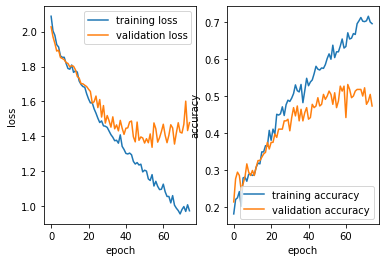

In [ ]:
plt.subplot(1,2,1)
plt.plot(history1.history['loss'])
plt.plot(history1.history['val_loss'])
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['training loss', 'validation loss'])

plt.subplot(1,2,2)
plt.plot(history1.history['accuracy'])
plt.plot(history1.history['val_accuracy'])
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.legend(['training accuracy', 'validation accuracy'])

In [ ]:
y_pred = model1.predict(X_val)
y_pred_ = np.argmax(y_pred, axis = 1)
y_val_ = np.argmax(y_val, axis = 1)
print(classification_report(y_val_, y_pred_))

7/7 [==============================] - 0s 17ms/step
              precision    recall  f1-score   support

           0       0.47      0.47      0.47        32
           1       0.68      0.84      0.75        32
           2       0.59      0.72      0.65        32
           3       0.43      0.31      0.36        32
           4       0.31      0.34      0.32        32
           5       0.24      0.19      0.21        32
           6       0.76      0.69      0.72        32

    accuracy                           0.51       224
   macro avg       0.50      0.51      0.50       224
weighted avg       0.50      0.51      0.50       224



Mapping:
0. Angry.
1. Calm.
2. Disgust.
3. Fear.
4. Happy.
5. Sad.
6. Surprise.

Text(0, 0.5, 'Prediction')

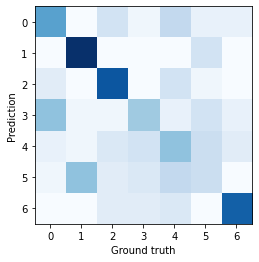

In [ ]:
cm = confusion_matrix(y_val_, y_pred_)
plt.imshow(cm, cmap = plt.cm.Blues)
plt.xlabel('Ground truth')
plt.ylabel('Prediction')

In [ ]:
print(top_k_accuracy_score(y_val_, y_pred, k = 2))
print(top_k_accuracy_score(y_val_, y_pred, k = 3))

0.7321428571428571
0.8482142857142857


## Model 2: augmented data

In [ ]:
X_val = X_train[896:1120]
y_val = y_train[896:1120]
# We don't have to pick the validation data augmented
to_remove = list(range(896, 1120)) + list(range(2016, 2240)) + list(range(3136, 3360)) + list(range(4256, 4480)) + list(range(5376, 5600)) 
X_train = np.delete(X_train, to_remove, axis = 0)
y_train = np.delete(y_train, to_remove, axis = 0)
X_train.shape, y_train.shape, X_val.shape, y_val.shape, X_test.shape, y_test.shape

((4480, 128, 282, 1),
 (4480, 7),
 (224, 128, 282, 1),
 (224, 7),
 (224, 128, 282, 1),
 (224, 7))

Now let's return to the original model and compare the performances if we use augmented data.

In [ ]:
num_classes = 7

model2 = Sequential()

model2.add(Conv2D(32, (3, 3), activation = 'relu', input_shape = (128, 282, 1)))
model2.add(MaxPooling2D((2, 2)))

model2.add(Conv2D(64, (3, 3), activation = 'relu'))
model2.add(MaxPooling2D((2, 2)))

model2.add(Conv2D(64, (3, 3), activation = 'relu'))
model2.add(GlobalMaxPooling2D())

model2.add(Dense(64, activation = 'relu'))

model2.add(Dense(num_classes, activation = 'softmax'))

model2.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 126, 280, 32)      320       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 63, 140, 32)      0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 61, 138, 64)       18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 30, 69, 64)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 28, 67, 64)        36928     
                                                                 
 global_max_pooling2d (Globa  (None, 64)               0

In [ ]:
stop_early = EarlyStopping(monitor = 'val_loss', patience = 10, restore_best_weights = True)

In [ ]:
model2.compile(loss = 'categorical_crossentropy', optimizer = Adam(learning_rate = 0.001), metrics = ['accuracy'])
history2 = model2.fit(X_train, y_train, batch_size = 32, epochs = 100, validation_data = (X_val, y_val), callbacks = [stop_early])

Epoch 1/100
140/140 [==============================] - 14s 35ms/step - loss: 1.8366 - accuracy: 0.2382 - val_loss: 1.7582 - val_accuracy: 0.3080
Epoch 2/100
140/140 [==============================] - 5s 34ms/step - loss: 1.7145 - accuracy: 0.3145 - val_loss: 1.7028 - val_accuracy: 0.3438
Epoch 3/100
140/140 [==============================] - 5s 34ms/step - loss: 1.6115 - accuracy: 0.3705 - val_loss: 1.6390 - val_accuracy: 0.3661
Epoch 4/100
140/140 [==============================] - 5s 34ms/step - loss: 1.5163 - accuracy: 0.4096 - val_loss: 1.5480 - val_accuracy: 0.3571
Epoch 5/100
140/140 [==============================] - 5s 34ms/step - loss: 1.3908 - accuracy: 0.4576 - val_loss: 1.4773 - val_accuracy: 0.4420
Epoch 6/100
140/140 [==============================] - 5s 34ms/step - loss: 1.2684 - accuracy: 0.5074 - val_loss: 1.3289 - val_accuracy: 0.4598
Epoch 7/100
140/140 [==============================] - 5s 34ms/step - loss: 1.1834 - accuracy: 0.5471 - val_loss: 1.3852 - val_accuracy

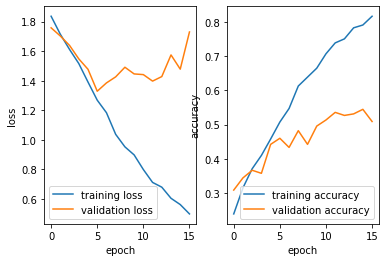

In [ ]:
plt.subplot(1,2,1)
plt.plot(history2.history['loss'])
plt.plot(history2.history['val_loss'])
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['training loss', 'validation loss'])

plt.subplot(1,2,2)
plt.plot(history2.history['accuracy'])
plt.plot(history2.history['val_accuracy'])
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.legend(['training accuracy', 'validation accuracy'])

In [ ]:
y_pred = model2.predict(X_val)
y_pred_ = np.argmax(y_pred, axis = 1)
y_val_ = np.argmax(y_val, axis = 1)
print(classification_report(y_val_, y_pred_))

7/7 [==============================] - 0s 13ms/step
              precision    recall  f1-score   support

           0       0.67      0.38      0.48        32
           1       0.64      0.66      0.65        32
           2       0.43      0.78      0.56        32
           3       0.39      0.41      0.40        32
           4       0.18      0.12      0.15        32
           5       0.20      0.16      0.18        32
           6       0.66      0.72      0.69        32

    accuracy                           0.46       224
   macro avg       0.45      0.46      0.44       224
weighted avg       0.45      0.46      0.44       224



Mapping:
0. Angry.
1. Calm.
2. Disgust.
3. Fear.
4. Happy.
5. Sad.
6. Surprise.

Text(0, 0.5, 'Prediction')

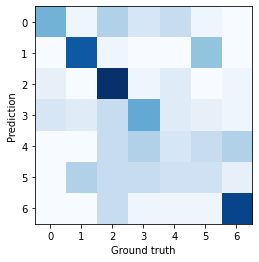

In [ ]:
cm = confusion_matrix(y_val_, y_pred_)
plt.imshow(cm, cmap = plt.cm.Blues)
plt.xlabel('Ground truth')
plt.ylabel('Prediction')

In [ ]:
print(top_k_accuracy_score(y_val_, y_pred, k = 2))
print(top_k_accuracy_score(y_val_, y_pred, k = 3))

0.6919642857142857
0.7946428571428571


## Model 3: fine-tuned aug

In [ ]:
X_val = X_train[896:1120]
y_val = y_train[896:1120]
# We don't have to pick the validation data augmented
to_remove = list(range(896, 1120)) + list(range(2016, 2240)) + list(range(3136, 3360)) + list(range(4256, 4480)) + list(range(5376, 5600)) 
X_train = np.delete(X_train, to_remove, axis = 0)
y_train = np.delete(y_train, to_remove, axis = 0)
X_train.shape, y_train.shape, X_val.shape, y_val.shape, X_test.shape, y_test.shape

((4480, 128, 282, 1),
 (4480, 7),
 (224, 128, 282, 1),
 (224, 7),
 (224, 128, 282, 1),
 (224, 7))

Due to insufficient RAM, we use the parameters found above in Grid Search CV.

In [ ]:
num_classes = 7

model3 = Sequential()

model3.add(Conv2D(32, (3, 3), activation = 'relu', input_shape = (128, 282, 1)))
model3.add(MaxPooling2D((2, 2)))

model3.add(Conv2D(64, (3, 3), activation = 'relu', kernel_regularizer = l2(0.001), bias_regularizer = l2(0.01)))
model3.add(MaxPooling2D((2, 2)))
model3.add(Dropout(0.2))

model3.add(Conv2D(64, (3, 3), activation = 'relu', kernel_regularizer = l2(0.001), bias_regularizer = l2(0.01)))
model3.add(GlobalMaxPooling2D())
model3.add(Dropout(0.2))

model3.add(Dense(64, activation = 'relu', kernel_regularizer = l2(0.001), bias_regularizer = l2(0.01)))
model3.add(Dropout(0.2))

model3.add(Dense(num_classes, activation = 'softmax'))

model3.summary()

Model: "sequential_16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_48 (Conv2D)          (None, 126, 280, 32)      320       
                                                                 
 max_pooling2d_31 (MaxPoolin  (None, 63, 140, 32)      0         
 g2D)                                                            
                                                                 
 conv2d_49 (Conv2D)          (None, 61, 138, 64)       18496     
                                                                 
 max_pooling2d_32 (MaxPoolin  (None, 30, 69, 64)       0         
 g2D)                                                            
                                                                 
 dropout_53 (Dropout)        (None, 30, 69, 64)        0         
                                                                 
 conv2d_50 (Conv2D)          (None, 28, 67, 64)      

In [ ]:
stop_early = EarlyStopping(monitor = 'val_loss', patience = 20, restore_best_weights = True)

In [ ]:
model3.compile(loss = 'categorical_crossentropy', optimizer = Adam(learning_rate = 0.001), metrics = ['accuracy'])
history3 = model3.fit(X_train, y_train, batch_size = 32, epochs = 200, validation_data = (X_val, y_val), callbacks = [stop_early])

Epoch 1/200
140/140 [==============================] - 6s 37ms/step - loss: 2.0186 - accuracy: 0.2188 - val_loss: 1.9134 - val_accuracy: 0.2812
Epoch 2/200
140/140 [==============================] - 5s 35ms/step - loss: 1.9097 - accuracy: 0.2516 - val_loss: 1.8792 - val_accuracy: 0.3393
Epoch 3/200
140/140 [==============================] - 5s 35ms/step - loss: 1.8249 - accuracy: 0.2931 - val_loss: 1.7738 - val_accuracy: 0.3348
Epoch 4/200
140/140 [==============================] - 5s 35ms/step - loss: 1.7709 - accuracy: 0.3268 - val_loss: 1.7980 - val_accuracy: 0.3393
Epoch 5/200
140/140 [==============================] - 5s 35ms/step - loss: 1.7149 - accuracy: 0.3531 - val_loss: 1.6739 - val_accuracy: 0.3839
Epoch 6/200
140/140 [==============================] - 5s 35ms/step - loss: 1.6333 - accuracy: 0.3926 - val_loss: 1.6599 - val_accuracy: 0.3795
Epoch 7/200
140/140 [==============================] - 5s 35ms/step - loss: 1.5676 - accuracy: 0.4172 - val_loss: 1.5728 - val_accuracy:

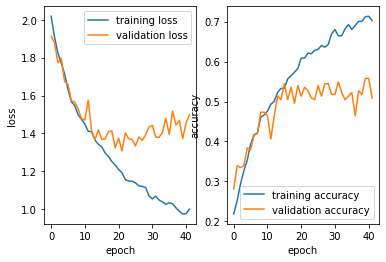

In [ ]:
plt.subplot(1,2,1)
plt.plot(history3.history['loss'])
plt.plot(history3.history['val_loss'])
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['training loss', 'validation loss'])

plt.subplot(1,2,2)
plt.plot(history3.history['accuracy'])
plt.plot(history3.history['val_accuracy'])
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.legend(['training accuracy', 'validation accuracy'])

In [ ]:
y_pred = model3.predict(X_val)
y_pred_ = np.argmax(y_pred, axis = 1)
y_val_ = np.argmax(y_val, axis = 1)
print(classification_report(y_val_, y_pred_))

7/7 [==============================] - 0s 15ms/step
              precision    recall  f1-score   support

           0       0.48      0.62      0.54        32
           1       0.67      0.91      0.77        32
           2       0.71      0.75      0.73        32
           3       0.42      0.41      0.41        32
           4       0.25      0.16      0.19        32
           5       0.35      0.25      0.29        32
           6       0.68      0.66      0.67        32

    accuracy                           0.54       224
   macro avg       0.51      0.54      0.51       224
weighted avg       0.51      0.54      0.51       224



Mapping:
0. Angry.
1. Calm.
2. Disgust.
3. Fear.
4. Happy.
5. Sad.
6. Surprise.

Text(0, 0.5, 'Prediction')

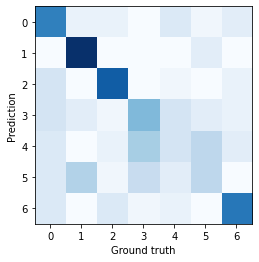

In [ ]:
cm = confusion_matrix(y_val_, y_pred_)
plt.imshow(cm, cmap = plt.cm.Blues)
plt.xlabel('Ground truth')
plt.ylabel('Prediction')

In [ ]:
print(top_k_accuracy_score(y_val_, y_pred, k = 2))
print(top_k_accuracy_score(y_val_, y_pred, k = 3))

0.7321428571428571
0.8839285714285714


## Model 3.1: double filters

We may try to double the number of filters for each layer.

In [ ]:
X_val = X_train[896:1120]
y_val = y_train[896:1120]
# We don't have to pick the validation data augmented
to_remove = list(range(896, 1120)) + list(range(2016, 2240)) + list(range(3136, 3360)) + list(range(4256, 4480)) + list(range(5376, 5600)) 
X_train = np.delete(X_train, to_remove, axis = 0)
y_train = np.delete(y_train, to_remove, axis = 0)
X_train.shape, y_train.shape, X_val.shape, y_val.shape, X_test.shape, y_test.shape

((4480, 128, 282, 1),
 (4480, 7),
 (224, 128, 282, 1),
 (224, 7),
 (224, 128, 282, 1),
 (224, 7))

In [ ]:
num_classes = 7

model31 = Sequential()

model31.add(Conv2D(64, (3, 3), activation = 'relu', input_shape = (128, 282, 1)))
model31.add(MaxPooling2D((2, 2)))

model31.add(Conv2D(128, (3, 3), activation = 'relu', kernel_regularizer = l2(0.001), bias_regularizer = l2(0.01)))
model31.add(MaxPooling2D((2, 2)))
model31.add(Dropout(0.2))

model31.add(Conv2D(128, (3, 3), activation = 'relu', kernel_regularizer = l2(0.001), bias_regularizer = l2(0.01)))
model31.add(GlobalMaxPooling2D())
model31.add(Dropout(0.2))

model31.add(Dense(128, activation = 'relu', kernel_regularizer = l2(0.001), bias_regularizer = l2(0.01)))
model31.add(Dropout(0.2))

model31.add(Dense(num_classes, activation = 'softmax'))

model31.summary()

Model: "sequential_15"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_45 (Conv2D)          (None, 126, 280, 64)      640       
                                                                 
 max_pooling2d_29 (MaxPoolin  (None, 63, 140, 64)      0         
 g2D)                                                            
                                                                 
 conv2d_46 (Conv2D)          (None, 61, 138, 128)      73856     
                                                                 
 max_pooling2d_30 (MaxPoolin  (None, 30, 69, 128)      0         
 g2D)                                                            
                                                                 
 dropout_50 (Dropout)        (None, 30, 69, 128)       0         
                                                                 
 conv2d_47 (Conv2D)          (None, 28, 67, 128)     

In [ ]:
stop_early = EarlyStopping(monitor = 'val_loss', patience = 20, restore_best_weights = True)

In [ ]:
model31.compile(loss = 'categorical_crossentropy', optimizer = Adam(learning_rate = 0.001), metrics = ['accuracy'])
history31 = model31.fit(X_train, y_train, batch_size = 32, epochs = 200, validation_data = (X_val, y_val), callbacks = [stop_early])

Epoch 1/200
140/140 [==============================] - 11s 72ms/step - loss: 2.1068 - accuracy: 0.2190 - val_loss: 1.9631 - val_accuracy: 0.2545
Epoch 2/200
140/140 [==============================] - 10s 70ms/step - loss: 1.9498 - accuracy: 0.2496 - val_loss: 1.8970 - val_accuracy: 0.2991
Epoch 3/200
140/140 [==============================] - 10s 70ms/step - loss: 1.8511 - accuracy: 0.2933 - val_loss: 1.8734 - val_accuracy: 0.3214
Epoch 4/200
140/140 [==============================] - 10s 70ms/step - loss: 1.7428 - accuracy: 0.3558 - val_loss: 1.7098 - val_accuracy: 0.3884
Epoch 5/200
140/140 [==============================] - 10s 70ms/step - loss: 1.6466 - accuracy: 0.3908 - val_loss: 1.6201 - val_accuracy: 0.4241
Epoch 6/200
140/140 [==============================] - 10s 70ms/step - loss: 1.5760 - accuracy: 0.4321 - val_loss: 1.5877 - val_accuracy: 0.4286
Epoch 7/200
140/140 [==============================] - 10s 70ms/step - loss: 1.5552 - accuracy: 0.4342 - val_loss: 1.5759 - val_ac

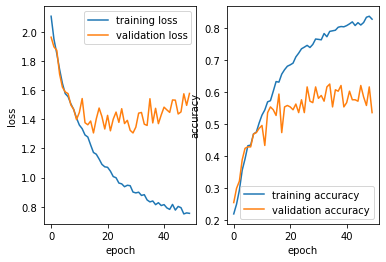

In [ ]:
plt.subplot(1,2,1)
plt.plot(history31.history['loss'])
plt.plot(history31.history['val_loss'])
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['training loss', 'validation loss'])

plt.subplot(1,2,2)
plt.plot(history31.history['accuracy'])
plt.plot(history31.history['val_accuracy'])
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.legend(['training accuracy', 'validation accuracy'])

In [ ]:
y_pred = model31.predict(X_val)
y_pred_ = np.argmax(y_pred, axis = 1)
y_val_ = np.argmax(y_val, axis = 1)
print(classification_report(y_val_, y_pred_))

7/7 [==============================] - 0s 25ms/step
              precision    recall  f1-score   support

           0       0.61      0.44      0.51        32
           1       0.75      0.84      0.79        32
           2       0.73      0.75      0.74        32
           3       0.51      0.59      0.55        32
           4       0.43      0.28      0.34        32
           5       0.48      0.69      0.56        32
           6       0.82      0.72      0.77        32

    accuracy                           0.62       224
   macro avg       0.62      0.62      0.61       224
weighted avg       0.62      0.62      0.61       224



Mapping:
0. Angry.
1. Calm.
2. Disgust.
3. Fear.
4. Happy.
5. Sad.
6. Surprise.

Text(0, 0.5, 'Prediction')

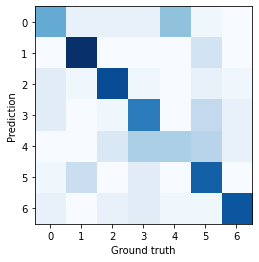

In [ ]:
cm = confusion_matrix(y_val_, y_pred_)
plt.imshow(cm, cmap = plt.cm.Blues)
plt.xlabel('Ground truth')
plt.ylabel('Prediction')

In [ ]:
print(top_k_accuracy_score(y_val_, y_pred, k = 2))
print(top_k_accuracy_score(y_val_, y_pred, k = 3))

0.7991071428571429
0.9196428571428571


## Model 3.2: rectangular kernel

We may try to change the kernel size to a rectangular shape, due to the rectangular shape of the mel spectrograms.

In [ ]:
X_val = X_train[896:1120]
y_val = y_train[896:1120]
# We don't have to pick the validation data augmented
to_remove = list(range(896, 1120)) + list(range(2016, 2240)) + list(range(3136, 3360)) + list(range(4256, 4480)) + list(range(5376, 5600)) 
X_train = np.delete(X_train, to_remove, axis = 0)
y_train = np.delete(y_train, to_remove, axis = 0)
X_train.shape, y_train.shape, X_val.shape, y_val.shape, X_test.shape, y_test.shape

((4480, 128, 282, 1),
 (4480, 7),
 (224, 128, 282, 1),
 (224, 7),
 (224, 128, 282, 1),
 (224, 7))

In [ ]:
num_classes = 7

model32 = Sequential()

model32.add(Conv2D(64, (3, 5), activation = 'relu', input_shape = (128, 282, 1)))
model32.add(MaxPooling2D((2, 2)))

model32.add(Conv2D(128, (3, 5), activation = 'relu', kernel_regularizer = l2(0.001), bias_regularizer = l2(0.01)))
model32.add(MaxPooling2D((2, 2)))
model32.add(Dropout(0.2))

model32.add(Conv2D(128, (3, 5), activation = 'relu', kernel_regularizer = l2(0.001), bias_regularizer = l2(0.01)))
model32.add(GlobalMaxPooling2D())
model32.add(Dropout(0.2))

model32.add(Dense(128, activation = 'relu', kernel_regularizer = l2(0.001), bias_regularizer = l2(0.01)))
model32.add(Dropout(0.2))

model32.add(Dense(num_classes, activation = 'softmax'))

model32.summary()

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_24 (Conv2D)          (None, 126, 278, 64)      1024      
                                                                 
 max_pooling2d_16 (MaxPoolin  (None, 63, 139, 64)      0         
 g2D)                                                            
                                                                 
 conv2d_25 (Conv2D)          (None, 61, 135, 128)      123008    
                                                                 
 max_pooling2d_17 (MaxPoolin  (None, 30, 67, 128)      0         
 g2D)                                                            
                                                                 
 dropout_24 (Dropout)        (None, 30, 67, 128)       0         
                                                                 
 conv2d_26 (Conv2D)          (None, 28, 63, 128)      

In [ ]:
stop_early = EarlyStopping(monitor = 'val_loss', patience = 20, restore_best_weights = True)

In [ ]:
model32.compile(loss = 'categorical_crossentropy', optimizer = Adam(learning_rate = 0.001), metrics = ['accuracy'])
history32 = model32.fit(X_train, y_train, batch_size = 32, epochs = 200, validation_data = (X_val, y_val), callbacks = [stop_early])

Epoch 1/200
140/140 [==============================] - 14s 93ms/step - loss: 2.1006 - accuracy: 0.2239 - val_loss: 2.0453 - val_accuracy: 0.1964
Epoch 2/200
140/140 [==============================] - 13s 91ms/step - loss: 1.9236 - accuracy: 0.2643 - val_loss: 1.9046 - val_accuracy: 0.2812
Epoch 3/200
140/140 [==============================] - 13s 90ms/step - loss: 1.8490 - accuracy: 0.2775 - val_loss: 1.8311 - val_accuracy: 0.2768
Epoch 4/200
140/140 [==============================] - 12s 89ms/step - loss: 1.7841 - accuracy: 0.3141 - val_loss: 1.7839 - val_accuracy: 0.3438
Epoch 5/200
140/140 [==============================] - 12s 89ms/step - loss: 1.7113 - accuracy: 0.3576 - val_loss: 1.7003 - val_accuracy: 0.3616
Epoch 6/200
140/140 [==============================] - 13s 95ms/step - loss: 1.5946 - accuracy: 0.4127 - val_loss: 1.5551 - val_accuracy: 0.4464
Epoch 7/200
140/140 [==============================] - 13s 89ms/step - loss: 1.4852 - accuracy: 0.4679 - val_loss: 1.4373 - val_ac

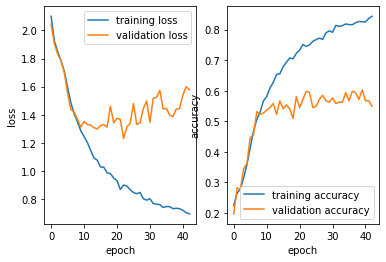

In [ ]:
plt.subplot(1,2,1)
plt.plot(history32.history['loss'])
plt.plot(history32.history['val_loss'])
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['training loss', 'validation loss'])

plt.subplot(1,2,2)
plt.plot(history32.history['accuracy'])
plt.plot(history32.history['val_accuracy'])
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.legend(['training accuracy', 'validation accuracy'])

In [ ]:
y_pred = model32.predict(X_val)
y_pred_ = np.argmax(y_pred, axis = 1)
y_val_ = np.argmax(y_val, axis = 1)
print(classification_report(y_val_, y_pred_))

7/7 [==============================] - 0s 36ms/step
              precision    recall  f1-score   support

           0       0.58      0.47      0.52        32
           1       0.72      0.88      0.79        32
           2       0.72      0.88      0.79        32
           3       0.52      0.44      0.47        32
           4       0.43      0.47      0.45        32
           5       0.45      0.41      0.43        32
           6       0.72      0.66      0.69        32

    accuracy                           0.60       224
   macro avg       0.59      0.60      0.59       224
weighted avg       0.59      0.60      0.59       224



Mapping:
0. Angry.
1. Calm.
2. Disgust.
3. Fear.
4. Happy.
5. Sad.
6. Surprise.

Text(0, 0.5, 'Prediction')

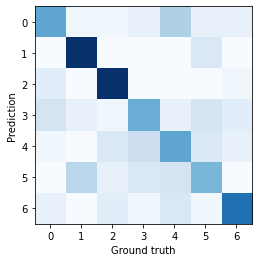

In [ ]:
cm = confusion_matrix(y_val_, y_pred_)
plt.imshow(cm, cmap = plt.cm.Blues)
plt.xlabel('Ground truth')
plt.ylabel('Prediction')

In [ ]:
print(top_k_accuracy_score(y_val_, y_pred, k = 2))
print(top_k_accuracy_score(y_val_, y_pred, k = 3))

0.8303571428571429
0.9196428571428571


# Saving and testing

Now we may merge training set and validation set in order to re-train all of our models on a bigger set of data. Then, we'll test the performances on the test set.

## Model 0

In [44]:
X_train_vanilla = X_train[:1120]
y_train_vanilla = y_train[:1120]

In [42]:
num_classes = 7

model0 = Sequential()

model0.add(Conv2D(32, (3, 3), activation = 'relu', input_shape = (128, 282, 1)))
model0.add(MaxPooling2D((2, 2)))

model0.add(Conv2D(64, (3, 3), activation = 'relu'))
model0.add(MaxPooling2D((2, 2)))

model0.add(Conv2D(64, (3, 3), activation = 'relu'))
model0.add(GlobalMaxPooling2D())

model0.add(Dense(64, activation = 'relu'))

model0.add(Dense(num_classes, activation = 'softmax'))

In [ ]:
model0.compile(loss = 'categorical_crossentropy', optimizer = Adam(learning_rate = 0.001), metrics = ['accuracy'])
history0 = model0.fit(X_train_vanilla, y_train_vanilla, batch_size = 32, epochs = 30)

In [46]:
y_pred = model0.predict(X_test)
y_pred_ = np.argmax(y_pred, axis = 1)
y_test_ = np.argmax(y_test, axis = 1)
print(classification_report(y_test_, y_pred_))

7/7 [==============================] - 0s 15ms/step
              precision    recall  f1-score   support

           0       0.33      0.81      0.46        32
           1       0.50      0.06      0.11        32
           2       0.38      0.50      0.43        32
           3       0.64      0.22      0.33        32
           4       0.37      0.34      0.35        32
           5       0.41      0.44      0.42        32
           6       0.70      0.50      0.58        32

    accuracy                           0.41       224
   macro avg       0.47      0.41      0.38       224
weighted avg       0.47      0.41      0.38       224



Text(0, 0.5, 'Prediction')

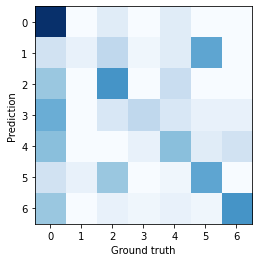

In [47]:
cm = confusion_matrix(y_test_, y_pred_)
plt.imshow(cm, cmap = plt.cm.Blues)
plt.xlabel('Ground truth')
plt.ylabel('Prediction')

In [48]:
print(top_k_accuracy_score(y_test_, y_pred, k = 2))
print(top_k_accuracy_score(y_test_, y_pred, k = 3))

0.6294642857142857
0.75


In [54]:
model0.save('/content/gdrive/MyDrive/Digital Signal/Models/Audio - CNN 2D/model0.h5')

## Model 1

In [49]:
num_classes = 7

model1 = Sequential()

model1.add(Conv2D(32, (3, 3), activation = 'relu', input_shape = (128, 282, 1)))
model1.add(MaxPooling2D((2, 2)))

model1.add(Conv2D(64, (3, 3), activation = 'relu', kernel_regularizer = l2(0.001), bias_regularizer = l2(0.01)))
model1.add(MaxPooling2D((2, 2)))
model1.add(Dropout(0.2))

model1.add(Conv2D(64, (3, 3), activation = 'relu', kernel_regularizer = l2(0.001), bias_regularizer = l2(0.01)))
model1.add(GlobalMaxPooling2D())
model1.add(Dropout(0.2))

model1.add(Dense(64, activation = 'relu', kernel_regularizer = l2(0.001), bias_regularizer = l2(0.01)))
model1.add(Dropout(0.2))

model1.add(Dense(num_classes, activation = 'softmax'))

In [ ]:
model1.compile(loss = 'categorical_crossentropy', optimizer = Adam(learning_rate = 0.001), metrics = ['accuracy'])
history1 = model1.fit(X_train_vanilla, y_train_vanilla, batch_size = 32, epochs = 70)

In [51]:
y_pred = model1.predict(X_test)
y_pred_ = np.argmax(y_pred, axis = 1)
y_test_ = np.argmax(y_test, axis = 1)
print(classification_report(y_test_, y_pred_))

7/7 [==============================] - 0s 13ms/step
              precision    recall  f1-score   support

           0       0.51      0.66      0.58        32
           1       0.73      0.34      0.47        32
           2       0.43      0.50      0.46        32
           3       0.56      0.47      0.51        32
           4       0.29      0.22      0.25        32
           5       0.39      0.34      0.37        32
           6       0.60      0.97      0.74        32

    accuracy                           0.50       224
   macro avg       0.50      0.50      0.48       224
weighted avg       0.50      0.50      0.48       224



Text(0, 0.5, 'Prediction')

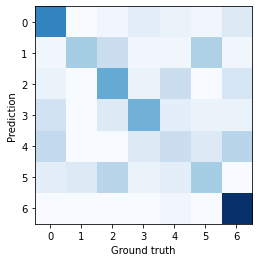

In [52]:
cm = confusion_matrix(y_test_, y_pred_)
plt.imshow(cm, cmap = plt.cm.Blues)
plt.xlabel('Ground truth')
plt.ylabel('Prediction')

In [53]:
print(top_k_accuracy_score(y_test_, y_pred, k = 2))
print(top_k_accuracy_score(y_test_, y_pred, k = 3))

0.71875
0.8035714285714286


In [55]:
model1.save('/content/gdrive/MyDrive/Digital Signal/Models/Audio - CNN 2D/model1.h5')

## Model 2

In [58]:
num_classes = 7

model2 = Sequential()

model2.add(Conv2D(32, (3, 3), activation = 'relu', input_shape = (128, 282, 1)))
model2.add(MaxPooling2D((2, 2)))

model2.add(Conv2D(64, (3, 3), activation = 'relu'))
model2.add(MaxPooling2D((2, 2)))

model2.add(Conv2D(64, (3, 3), activation = 'relu'))
model2.add(GlobalMaxPooling2D())

model2.add(Dense(64, activation = 'relu'))

model2.add(Dense(num_classes, activation = 'softmax'))

In [ ]:
model2.compile(loss = 'categorical_crossentropy', optimizer = Adam(learning_rate = 0.001), metrics = ['accuracy'])
history2 = model2.fit(X_train, y_train, batch_size = 32, epochs = 10)

In [63]:
y_pred = model2.predict(X_test)
y_pred_ = np.argmax(y_pred, axis = 1)
y_test_ = np.argmax(y_test, axis = 1)
print(classification_report(y_test_, y_pred_))

7/7 [==============================] - 0s 15ms/step
              precision    recall  f1-score   support

           0       0.31      0.72      0.43        32
           1       0.76      0.41      0.53        32
           2       0.53      0.53      0.53        32
           3       0.50      0.34      0.41        32
           4       0.31      0.12      0.18        32
           5       0.34      0.31      0.33        32
           6       0.69      0.78      0.74        32

    accuracy                           0.46       224
   macro avg       0.49      0.46      0.45       224
weighted avg       0.49      0.46      0.45       224



Text(0, 0.5, 'Prediction')

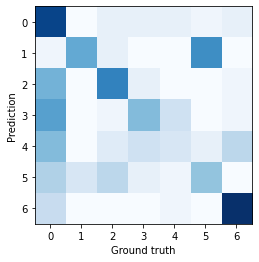

In [64]:
cm = confusion_matrix(y_test_, y_pred_)
plt.imshow(cm, cmap = plt.cm.Blues)
plt.xlabel('Ground truth')
plt.ylabel('Prediction')

In [65]:
print(top_k_accuracy_score(y_test_, y_pred, k = 2))
print(top_k_accuracy_score(y_test_, y_pred, k = 3))

0.7098214285714286
0.8392857142857143


In [66]:
model2.save('/content/gdrive/MyDrive/Digital Signal/Models/Audio - CNN 2D/model2.h5')

## Model 3

In [67]:
num_classes = 7

model3 = Sequential()

model3.add(Conv2D(32, (3, 3), activation = 'relu', input_shape = (128, 282, 1)))
model3.add(MaxPooling2D((2, 2)))

model3.add(Conv2D(64, (3, 3), activation = 'relu', kernel_regularizer = l2(0.001), bias_regularizer = l2(0.01)))
model3.add(MaxPooling2D((2, 2)))
model3.add(Dropout(0.2))

model3.add(Conv2D(64, (3, 3), activation = 'relu', kernel_regularizer = l2(0.001), bias_regularizer = l2(0.01)))
model3.add(GlobalMaxPooling2D())
model3.add(Dropout(0.2))

model3.add(Dense(64, activation = 'relu', kernel_regularizer = l2(0.001), bias_regularizer = l2(0.01)))
model3.add(Dropout(0.2))

model3.add(Dense(num_classes, activation = 'softmax'))

In [68]:
model3.compile(loss = 'categorical_crossentropy', optimizer = Adam(learning_rate = 0.001), metrics = ['accuracy'])
history3 = model3.fit(X_train, y_train, batch_size = 32, epochs = 40)

In [69]:
y_pred = model3.predict(X_test)
y_pred_ = np.argmax(y_pred, axis = 1)
y_test_ = np.argmax(y_test, axis = 1)
print(classification_report(y_test_, y_pred_))

7/7 [==============================] - 0s 15ms/step
              precision    recall  f1-score   support

           0       0.52      0.53      0.52        32
           1       0.71      0.78      0.75        32
           2       0.61      0.72      0.66        32
           3       0.69      0.28      0.40        32
           4       0.40      0.44      0.42        32
           5       0.55      0.34      0.42        32
           6       0.62      0.97      0.76        32

    accuracy                           0.58       224
   macro avg       0.59      0.58      0.56       224
weighted avg       0.59      0.58      0.56       224



Text(0, 0.5, 'Prediction')

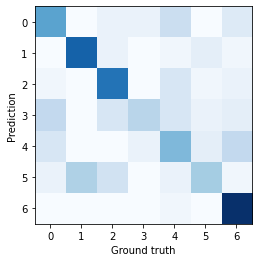

In [70]:
cm = confusion_matrix(y_test_, y_pred_)
plt.imshow(cm, cmap = plt.cm.Blues)
plt.xlabel('Ground truth')
plt.ylabel('Prediction')

In [71]:
print(top_k_accuracy_score(y_test_, y_pred, k = 2))
print(top_k_accuracy_score(y_test_, y_pred, k = 3))

0.7946428571428571
0.8705357142857143


In [72]:
model3.save('/content/gdrive/MyDrive/Digital Signal/Models/Audio - CNN 2D/model3.h5')

## Model 3.1

In [47]:
num_classes = 7

model31 = Sequential()

model31.add(Conv2D(64, (3, 3), activation = 'relu', input_shape = (128, 282, 1)))
model31.add(MaxPooling2D((2, 2)))

model31.add(Conv2D(128, (3, 3), activation = 'relu', kernel_regularizer = l2(0.001), bias_regularizer = l2(0.01)))
model31.add(MaxPooling2D((2, 2)))
model31.add(Dropout(0.2))

model31.add(Conv2D(128, (3, 3), activation = 'relu', kernel_regularizer = l2(0.001), bias_regularizer = l2(0.01)))
model31.add(GlobalMaxPooling2D())
model31.add(Dropout(0.2))

model31.add(Dense(128, activation = 'relu', kernel_regularizer = l2(0.001), bias_regularizer = l2(0.01)))
model31.add(Dropout(0.2))

model31.add(Dense(num_classes, activation = 'softmax'))

In [ ]:
model31.compile(loss = 'categorical_crossentropy', optimizer = Adam(learning_rate = 0.001), metrics = ['accuracy'])
history31 = model31.fit(X_train, y_train, batch_size = 32, epochs = 30, verbose = 0)

In [49]:
y_pred = model31.predict(X_test)
y_pred_ = np.argmax(y_pred, axis = 1)
y_test_ = np.argmax(y_test, axis = 1)
print(classification_report(y_test_, y_pred_))

7/7 [==============================] - 0s 26ms/step
              precision    recall  f1-score   support

           0       0.45      0.75      0.56        32
           1       0.63      0.84      0.72        32
           2       0.55      0.69      0.61        32
           3       0.82      0.28      0.42        32
           4       0.48      0.41      0.44        32
           5       0.60      0.09      0.16        32
           6       0.67      0.94      0.78        32

    accuracy                           0.57       224
   macro avg       0.60      0.57      0.53       224
weighted avg       0.60      0.57      0.53       224



Text(0, 0.5, 'Prediction')

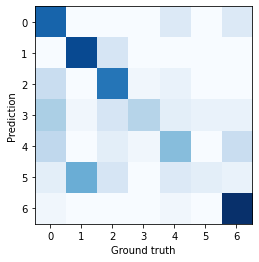

In [50]:
cm = confusion_matrix(y_test_, y_pred_)
plt.imshow(cm, cmap = plt.cm.Blues)
plt.xlabel('Ground truth')
plt.ylabel('Prediction')

In [51]:
print(top_k_accuracy_score(y_test_, y_pred, k = 2))
print(top_k_accuracy_score(y_test_, y_pred, k = 3))

0.7633928571428571
0.8705357142857143


In [52]:
model31.save('/content/gdrive/MyDrive/Digital Signal/Models/Audio - CNN 2D/model3_1.h5')

## Model 3.2

In [74]:
num_classes = 7

model32 = Sequential()

model32.add(Conv2D(64, (3, 5), activation = 'relu', input_shape = (128, 282, 1)))
model32.add(MaxPooling2D((2, 2)))

model32.add(Conv2D(128, (3, 5), activation = 'relu', kernel_regularizer = l2(0.001), bias_regularizer = l2(0.01)))
model32.add(MaxPooling2D((2, 2)))
model32.add(Dropout(0.2))

model32.add(Conv2D(128, (3, 5), activation = 'relu', kernel_regularizer = l2(0.001), bias_regularizer = l2(0.01)))
model32.add(GlobalMaxPooling2D())
model32.add(Dropout(0.2))

model32.add(Dense(128, activation = 'relu', kernel_regularizer = l2(0.001), bias_regularizer = l2(0.01)))
model32.add(Dropout(0.2))

model32.add(Dense(num_classes, activation = 'softmax'))

In [ ]:
model32.compile(loss = 'categorical_crossentropy', optimizer = Adam(learning_rate = 0.001), metrics = ['accuracy'])
history32 = model32.fit(X_train, y_train, batch_size = 32, epochs = 30) 

In [76]:
y_pred = model32.predict(X_test)
y_pred_ = np.argmax(y_pred, axis = 1)
y_test_ = np.argmax(y_test, axis = 1)
print(classification_report(y_test_, y_pred_))

7/7 [==============================] - 0s 29ms/step
              precision    recall  f1-score   support

           0       0.59      0.69      0.64        32
           1       0.65      1.00      0.79        32
           2       0.61      0.88      0.72        32
           3       0.93      0.44      0.60        32
           4       0.52      0.44      0.47        32
           5       0.54      0.22      0.31        32
           6       0.78      0.91      0.84        32

    accuracy                           0.65       224
   macro avg       0.66      0.65      0.62       224
weighted avg       0.66      0.65      0.62       224



Text(0, 0.5, 'Prediction')

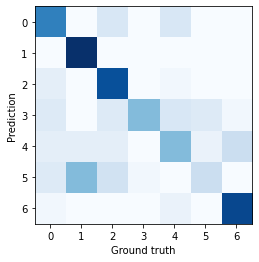

In [77]:
cm = confusion_matrix(y_test_, y_pred_)
plt.imshow(cm, cmap = plt.cm.Blues)
plt.xlabel('Ground truth')
plt.ylabel('Prediction')

In [78]:
print(top_k_accuracy_score(y_test_, y_pred, k = 2))
print(top_k_accuracy_score(y_test_, y_pred, k = 3))

0.8482142857142857
0.9419642857142857


In [79]:
model32.save('/content/gdrive/MyDrive/Digital Signal/Models/Audio - CNN 2D/model3_2.h5')